In [65]:
import torch
import numpy as np
from drink_db import recipe, vector_holder, ingredient_handler,unit_converter,drink_index
import secrets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import secrets
from torch.utils.data import DataLoader

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0
True


In [172]:
class drink_generator :
    def __init__(self,num_flavors,max_ingredients) :
        self.num_flavors=num_flavors
        self.max_ingredients=max_ingredients
        self.randomizer= secrets.SystemRandom()
        
    def generate_empty(self) :
        vector=np.zeros([self.num_flavors])
        return vector
        
    def generate_ingredient(self) :
        #this is to skew towards more 0s
        vector=np.empty([self.num_flavors])
        for index in range(self.num_flavors) :
            val=self.randomizer.randint(-100,100)
            if val<0:val=0
            val=val/100
            vector[index]=val
        return vector
    
    def fill_out_recipe(self,recipe,fill_to=9) :
        if (diff:=fill_to-len(recipe))>0 :
            if isinstance(recipe,np.ndarray) :
                for i in range(diff) :
                    recipe=np.append(recipe,[self.generate_empty()], axis=0)
            else :
                for i in range(diff) :
                    recipe.append(self.generate_empty())
        return recipe
    
    
    def generate_recipe_matrix(self) :
        num_ingredients=self.randomizer.randint(2,self.max_ingredients)
        total_volume=0
        volumes=[]
        recipe=[]
        for i in range(num_ingredients) :
            volume=self.randomizer.randint(1,100)
            total_volume+=volume
            volumes.append(volume)
            ingredient=self.generate_ingredient()
            recipe.append(ingredient)
            
        for ingredient,volume in zip(recipe,volumes) :
            volume=volume/total_volume
#             print(volume)
#             print(ingredient)
            ingredient=ingredient*volume
#             print(ingredient)
        recipe=[x for _,x in sorted(zip(volumes,recipe), key=lambda pair: pair[0],reverse=True)]
        return recipe
    
    def convert_to_recipe(self,ingredient_matrix) :
        recipe=np.sum(ingredient_matrix, axis=0, keepdims=True) 
        return recipe
            
            
            
            

In [173]:
dg=drink_generator(31,7)
# for i in range(20) :
# print(dg.generate_recipe_matrix())

## Display methods ##

In [113]:
def plot_matrix(matrix,names=None,title="") :
    
#     data = [[1, 0, 1], [2, 1, 2], [3, 2, 30]]
#     print(data)

#     plt.imshow(data, interpolation='nearest')
    plt.imshow(matrix, cmap='Blues', interpolation='nearest', origin='lower')

    if names is not None :
        plt.yticks(range(len(names)), names, fontsize='12')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    
def print_data(matrix) :
    if isinstance(matrix, torch.Tensor) :
        matrix=matrix.detach().numpy()
    if len(list(matrix.shape))==4 :
        plot_matrix(matrix[0][0],title=matrix.shape)
    elif len(list(matrix.shape))==2 :
        plot_matrix(matrix,title=matrix.shape)
    else :
        print("UNKNOWN SHAPE",matrix.shape)

# Permutation and distrobution information #
The number of ingredients forms a fairly normal distrobution with the numbers as follows:

## Numbers ##

| ingredients | number of recipes |
| --- | --- |
| 2 | 8 |
| 3 | 44 |
| 4 | 74 |
| 5 | 32 |
| 6 | 13 |
| 7 | 1 |


## Percentages ##

| ingredients | percentages |
| --- | --- |
| 2 | 4.5% |
| 3 | 25.0% |
| 4 | 42.0% |
| 5 | 18.0% |
| 6 | 7.0% |%
| 7 | .05% |


## Permutation distrobutions ##
4 ingredients can generate 24 permutations, so an attempt to keep the number of permutation similr for other drinks is in order, while still having a reasonable sampling of each recipe.

I ended up simply attempting to get the closes posible distrobution curves for total number of permutations, which was definitely not possble.

This ends up generating the following number of permutations for values greater than 4.

| ingredients | permutations |
| --- | --- |
| 5 | 28 |
| 6 | 30 |
| 7 | 25 |
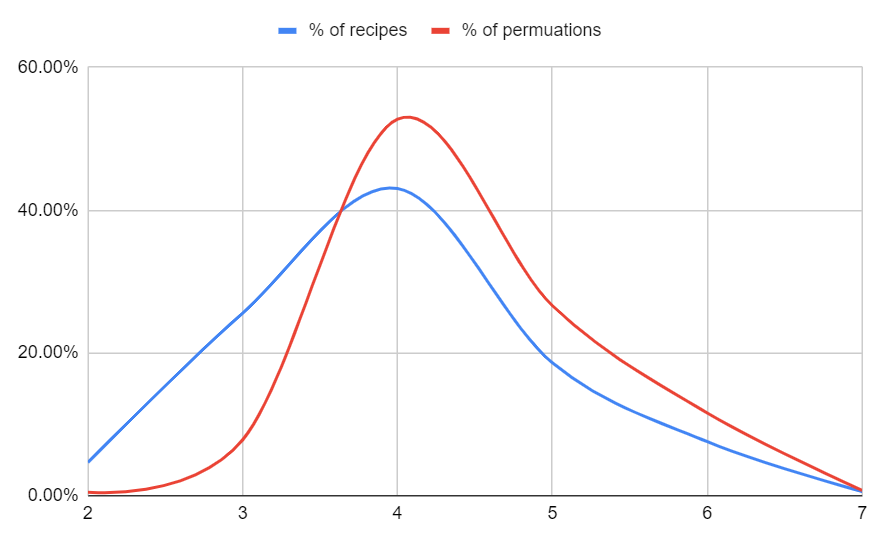


In [174]:
def get_permutations(matrix,fill_to=9,permutation_limits={5:28,6:30,7:25,9:120}) :
    '''This generates permutations of the passed in data. The max requirement is there as to not generate too many augmentations. 
    A recipe with 9 ingredients has 362880 permutations, which would significantly skew the dataset.'''
    permutations=list(itertools.permutations(matrix))
    selected_permutations=[]
    
    if len(matrix) in permutation_limits.keys() :
        num_to_get=permutation_limits[len(matrix)]
        
        while len(selected_permutations)<num_to_get :
            selected_permutations.append(secrets.choice(permutations))
    else :
        selected_permutations=permutations

    trimmed_permutations=[]
    if len(matrix)<fill_to :
            
        trimmed_permutations=[dg.fill_out_recipe(list(p)) for p in selected_permutations]
    else :
        trimmed_permutations=[list(p) for p in selected_permutations]
    return np.array(trimmed_permutations)

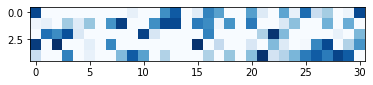

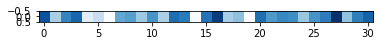

5
(28, 9, 31)


In [175]:
#testing data generation methods
recipe=dg.generate_recipe_matrix()
plot_matrix(recipe)
plot_matrix(dg.convert_to_recipe(recipe))

# print(list(itertools.permutations([1,2,3])))
# print(len(list(itertools.permutations([1,2,3]))))
print(len(recipe))
print(get_permutations(recipe).shape)

## Getting useable recipes ##

In [69]:
drink_db=drink_index(interactive=False)
search_terms=drink_db.parse_search("$vector")
results=drink_db.subset_search(search_terms)
print(len(results))

172


## Getting information about recipes and ingredients ##

In [70]:
ih=ingredient_handler()

def get_closest_recipe(recipe,recipe_list,ingredient_handler) :
	dist = np.linalg.norm(ingredient_handler.get_recipe_vector(recipe)-ingredient_handler.get_recipe_vector(recipe_list[0]))
	closest=recipe_list[0]
	for comp_recipe in recipe_list[1:] :
		if comp_recipe.id != recipe.id :
			new_dist = np.linalg.norm(ingredient_handler.get_recipe_vector(recipe)-ingredient_handler.get_recipe_vector(comp_recipe))
			if new_dist<dist :
				dist=new_dist
				closest=comp_recipe
	return closest,dist

def sort_by_closeness(recipe_list, ingredient_handler) :
    new_list=[recipe_list.pop()]
    dist_list=[]
    while len(recipe_list)>0 :
        current_recipe=new_list[-1]
        closest,dist=get_closest_recipe(current_recipe,recipe_list,ingredient_handler)
        new_list.append(recipe_list.pop(recipe_list.index(closest)))
        dist_list.append(dist)
    return new_list,dist_list


results,dists=sort_by_closeness(results,ih)

In [71]:
sorted_dists=sorted(dists)
# print(sorted_dists)
max_num=3
counter=0
for d in sorted_dists[3:]:
    i=dists.index(d)
    prev=results[i]
    dist_to=results[i+1]
    if prev.name != dist_to.name :
        print(prev)
        print(d)
        print(dist_to)
        counter+=1
    if counter>=max_num :
        break

corpse revivor #2
 codex
 page 188
 shake
 0.75 oz lillet blanc
 0.75 oz lemon juice
 0.75 oz gin
 0.75 oz cointreau
 2.0 dashes absinthe

0.015374473559114149
corpse reviver no2
 internet
 page 
 shaken
 3.0 cl lillet
 3.0 cl lemon juice
 3.0 cl gin
 3.0 cl cointreau
 1.0 dash absinthe

martini
 codex
 page 77
 stir and strain
 rated 3.00/5
 2.0 oz gin
 1.0 oz dry vermouth

0.018063388462946577
ideal gin martini
 codex
 page 62
 stir and strain
 2.0 oz gin
 1.0 oz dry vermouth
 1.0 dash orange bitters

gin sour
 diffords guide
 page 
 shaken
 2.0 oz gin
 1.0 oz lemon juice
 0.5 oz simple syrup
 3.0 dashes angostura

0.02956297773621396
fitzgerald
 diffords guide
 page 
 shaken
 1.66 oz gin
 25.0 ml lemon juice
 0.5 oz simple syrup
 2.0 dashes angostura



These results show that a distance of about 0.06 is the minimum required difference between different drinks that are not just variations on eachother.

In [72]:
distances=[]
ingredients=ih.ingredients
for ingredient in ingredients :
    for to_ingredient in ingredients :
        if ingredient is not to_ingredient :
#         if not bool(ingredient.names & to_ingredient.names) :
            dist = np.linalg.norm(ingredient.get_flavors()-to_ingredient.get_flavors())
            distances.append((ingredient,to_ingredient,dist))
            
            
combined_list=[(x,y,z) for x,y,z in sorted(distances, key=lambda pair: pair[2],reverse=False)]
# print(combined_list)
def print_info(to_print) :
    for one,two,dist in to_print :
        print(list(one.names)[0])
        print(dist)
        print(list(two.names)[0]) 
        print()


print_info(combined_list[-6:-1])

mint
2.315167380558045
orgeat syrup

orgeat syrup
2.315167380558045
mint

lemon juice
2.32379000772445
orgeat syrup

orgeat syrup
2.32379000772445
lemon juice

peychauds bitters
2.5059928172283334
orgeat syrup



Distances between ingredients range from ~0.6 to 2.5, however .9 seems to be a good cutoff for actually being similar

## generate recipe matrixes for all recipes and make dataloaders ##

In [119]:
def get_recipe_matrix(recipe,fill=False) :
    volumes,recipe_vector=ih.get_recipe_vectors(recipe,get_volumes=True)
    
    matrix=np.zeros((len(recipe_vector),31))
    for i in range(len(volumes)) :
        volume=[volumes[i]]
        vector=recipe_vector[i].get_flavors()
        row=np.insert(vector, 0, volume, axis=0)
#         print(len(row))
#         matrix[i]=[np.append(matrix,row)]
        matrix[i]=row
    
#     print(matrix)
#     print(matrix.shape)
    if fill :
        matrix=dg.fill_out_recipe(matrix)
    return matrix

In [185]:
recipe_name_matrices=[]

unaugmented_matrices=[]
shuffled_matrices=[]
full_shuffled_matrices=[]
recipe_matrices=[]


for recipe in results :
    matrix=get_recipe_matrix(recipe,False)
    recipe_name_matrices.append((recipe,dg.fill_out_recipe(matrix)))
    
    #The different datasets
    #unaugmented
    unaugmented_matrices.append(dg.fill_out_recipe(matrix))
    #shuffle only ingredients
    shuffled_matrices.extend(get_permutations(matrix))
    #shuffle in whitespace
    full_shuffled_matrices.extend(get_permutations(dg.fill_out_recipe(matrix)))
    #summed recipes
    recipe_matrices.append(dg.convert_to_recipe(matrix))
    

print("unaugmented",len(unaugmented_matrices))
print("shuffle only ingredients",len(shuffled_matrices))
print("shuffle in whitespace",len(full_shuffled_matrices))
print("summed recipes",len(recipe_matrices))

    



unaugmented 172
shuffle only ingredients 3367
shuffle in whitespace 20640
summed recipes 172


sorted by volume


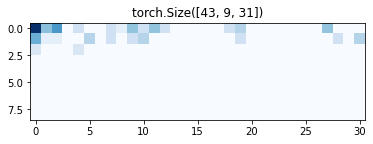

randomized order, but followed by empty


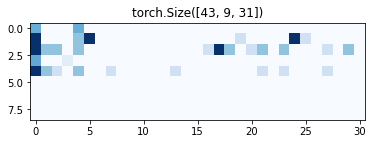

randomized order with shuffled empty


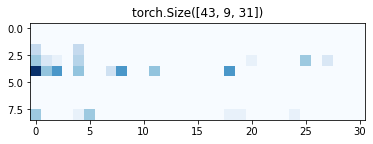

summed into single flavor profile


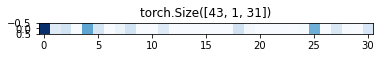

In [194]:
print("sorted by volume")
unaugmented_dataloader = DataLoader(unaugmented_matrices, batch_size=43, shuffle=True)
real_batch=next(iter(unaugmented_dataloader))
plot_matrix(real_batch[0],title=real_batch.shape)

print("randomized order, but followed by empty")

shuffled_dataloader = DataLoader(shuffled_matrices, batch_size=43, shuffle=True)
real_batch=next(iter(shuffled_dataloader))
plot_matrix(real_batch[0],title=real_batch.shape)

print("randomized order with shuffled empty")

full_shuffle_dataloader = DataLoader(full_shuffled_matrices, batch_size=43, shuffle=True)
real_batch=next(iter(full_shuffle_dataloader))
plot_matrix(real_batch[0],title=real_batch.shape)

print("summed into single flavor profile")
recipe_dataloader = DataLoader(recipe_matrices, batch_size=43, shuffle=True)
real_batch=next(iter(recipe_dataloader))
plot_matrix(real_batch[0],title=real_batch.shape)


## Now for the GAN ##

There are a couple ways I can go about this
## Generator ##
At the moment I can think of two methods to have the generator make an ingredient.

- The first of these is going from 1,100,1,1 to 1,1,9,31. I only need 8, however I am unable to acheive that with a consistant kernal.

- The second is to generate a 1d output with 8 channels, one per ingredient.

## Processing ##
Theres a couple ways to go about this.

- First and foremost; doing nothing. Just passing the raw data along. This is 2 possible outputs for the two generator methods.

- Second: Find the closest ingredient to the row and replace it with the appropriate values. I would only do this if the row is close enough to an ingredient, otherwise it would be made empty
   
Instead of passing each of the above along:
- Sum each matrix to be a 1,1,30,1 flavor vector, and use a dense NN to discriminate. 
    This has the benifit of being a more comprehensize flavor profile, without losing ingredient data.
    
## Descriminator ##
These options are basically limited by the processing
- 1,1,9,31
- 1,1,1,31
- or an ANN discriminator

HOWEVER: There are also data augmentation options. Though these only apply to the discriminator, they affect how the code would be generated.

### Augmentations ###
- Unshuffled, most to least volume
    - this is filled out with 0s for the 2d recipes
- shuffled
This generates a good number of augmentations, and may help avoid mode collapse.
    - For 2d recipes :
        - shuffle only the ingredients, fill bottom with blank space
        - shuffle blank space between recipes
        I truly have no idea if this will produce better or worse results, but I think its very likel it will require more training
    - for 1d recipes there is only shuffling or not 
    


# Conclusions #
It only makes sense to train them all.

- So there are 2d and 1d outputs (neither of which are truly that) and for each :
- replace, and not replace :
- and for each of those, sum and not sum
- and for all not sum, shuffle, not shuffle, and full shuffle

So a total of 14 combinations, which is perfectly within reason. 



In [185]:
shape_types=["2d","1d"]
to_replace=[True,False]
to_sum=[True,False]
to_shuffle=[True,False]
shuffle_2d=["partial shuffle","full shuffle"]

permutations=[]

for shape in shape_types :
    for replace in to_replace :
        for sum_val in to_sum :
            r="keep vectors"
            if replace : r="replace vectors"
            s="matrix"
            if sum_val : s="sum"
            
            a="" #augment
            if not sum_val : #if the data is not being summed into a single vector
                for shuffle in to_shuffle :
                    if shuffle : 
                        if shape=="1d" :
                            a="shuffle"
                            description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                             print(description)
                            permutations.append(description)
                        else :
                            for shuffle_val in shuffle_2d :
                                a=shuffle_val
                                description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                                 name="{}\t{}\t\t{}\t{}\n".format(shape,r,s,a)
#                                 print(description)
                                permutations.append(description)
                                
                    else :
                        a="no shuffle"
                        description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                         print(description)
                        permutations.append(description)
                        
            else :
                description="{}\t{}\t\t{}\t\t{}\n".format(shape,r,s,a)
#                 print(description)
                permutations.append(description)
                    
            
for name in permutations :
    print(name)
print(len(permutations),"permutations")

2d	replace vectors		sum		

2d	replace vectors		matrix		partial shuffle

2d	replace vectors		matrix		full shuffle

2d	replace vectors		matrix		no shuffle

2d	keep vectors		sum		

2d	keep vectors		matrix		partial shuffle

2d	keep vectors		matrix		full shuffle

2d	keep vectors		matrix		no shuffle

1d	replace vectors		sum		

1d	replace vectors		matrix		shuffle

1d	replace vectors		matrix		no shuffle

1d	keep vectors		sum		

1d	keep vectors		matrix		shuffle

1d	keep vectors		matrix		no shuffle

14 permutations


In [207]:
def check_for_settings(goal_dimention,num_layers,start_dimention) :
    '''This function does the math to see if a set kernal settings can generate the wanted output after a certain number of layers'''
    kernal_range=[2,30]
    padding_range=[0,10]
    stride_range=[1,10]
    out_padding_range=[0,10]

    for kernal in range(kernal_range[0],kernal_range[1]) :
        for padding in range(padding_range[0],padding_range[1]) :
            for stride in range(stride_range[0],stride_range[1]) :
                for out_padding in range(out_padding_range[0],out_padding_range[1]) :
                    last_height=start_dimention
                    for i in range(num_layers) :
                        last_height=(last_height-1)*stride-2*padding+(kernal-1)+out_padding+1
                    if last_height==goal_dimention:#or last_height==29 :
                        print("kernal",kernal)
                        print("padding",padding)
                        print("stride",stride)
                        print("out_padding",out_padding)
#                         print("i",i+1)
                        print()

check_for_settings(30,4,1)    
    
# print(last_height)

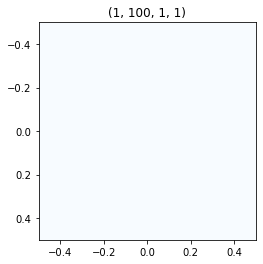

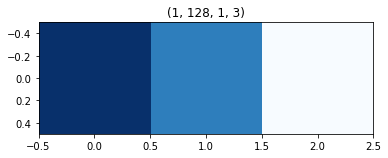

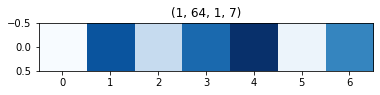

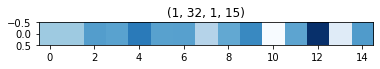

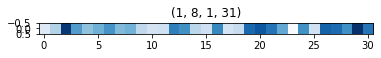

In [98]:
kernal_shape=(1,3)
stride=(1,2)
padding=(0,0)
output_padding=(0,0)

c0=nn.ConvTranspose2d(100,128, kernal_shape, stride, padding, output_padding=output_padding,bias=False)
c1=nn.ConvTranspose2d(128,64, kernal_shape, stride, padding,  output_padding=output_padding,bias=False)
c2=nn.ConvTranspose2d(64,32, kernal_shape, stride, padding,  output_padding=output_padding,bias=False)
c3=nn.ConvTranspose2d(32,8, kernal_shape, stride, padding,  output_padding=output_padding,bias=False)

#batch,channels,y,x
test_in=torch.randn(1,100, 1,1)
print_data(test_in)
out0=c0(test_in)
print_data(out0)
out1=c1(out0)
print_data(out1)
out2=c2(out1)
print_data(out2)
out3=c3(out2)
print_data(out3)

# Start assembling network #
Build the generators and discriminators

In [149]:
# kernal_shape=(3,7)
# stride=(1,2)
# padding=(0,2)
# output_padding=(0,0)

kernal_shape2d=(3,3)
kernal_shape1d=(1,3)

stride=(1,2)
padding=(0,0)
output_padding=(0,0)

class Generator2D(nn.Module):
    def __init__(self):
        super(Generator2D, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128, kernal_shape2d, stride, padding, output_padding=output_padding,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, kernal_shape2d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32, kernal_shape2d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,1, kernal_shape2d, stride, padding,  output_padding=output_padding,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

class Discriminator2D(nn.Module):
    def __init__(self):
        super(Discriminator2D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1,32, kernal_shape2d, stride, padding, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32,64, kernal_shape2d, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128, kernal_shape2d, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,1, kernal_shape2d, stride, padding, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    

class Generator1D(nn.Module):
    def __init__(self):
        super(Generator1D, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128, kernal_shape1d, stride, padding, output_padding=output_padding,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, kernal_shape1d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32, kernal_shape1d, stride, padding,  output_padding=output_padding,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,8, kernal_shape1d, stride, padding,  output_padding=output_padding,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

class Discriminator1D(nn.Module):
    def __init__(self):
        super(Discriminator1D, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(8,32, kernal_shape1d, stride, padding, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32,64, kernal_shape1d, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128, kernal_shape1d, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,1, kernal_shape1d, stride, padding, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    
#Hidden neurons chosen to be <2x input
class DiscriminatorLinear(nn.Module):
    def __init__(self):
        super(DiscriminatorLinear, self).__init__()
        self.main = nn.Sequential(
            nn.linear(31,32),
            nn.linear(32,16),
            nn.linear(16,1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Helper function and device selection

In [150]:
#custom weights initialization
#taken from a pytorch tutorial
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#Select the available device
if torch.cuda.is_available() :
    device=torch.device("cuda")
else :device=torch.device("cpu")
    
print(device)

cuda


In [151]:
def get_nearest_ingredient(row,cutoff=0.9) :
    '''for converting generated arrays to the nearest ingredient, if they are close enough'''
    percent=row[0]
    pseudo_ingredient=(1/percent)*row[1:]
    lowest_dist=50
    nearest=None
    for ingredient in ih.ingredients :
        dist = np.linalg.norm(pseudo_ingredient-ingredient.get_flavors())
        if dist<lowest_dist :
            lowest_dist=dist
            nearest=ingredient
            
    if nearest is not None or lowest_dist>cutoff :
        return np.zeros([31])
    else :
        scaled_ingredient=[percent]
        scaled_ingredient.extend(percent*np.copy(nearest.get_flavors()))
        return np.array(scaled_ingredient)


    

def convert_tensor_to_recipe(ingredient_matrix) :
    recipe=torch.sum(ingredient_matrix, dim=2, keepdim=True) 
    return recipe

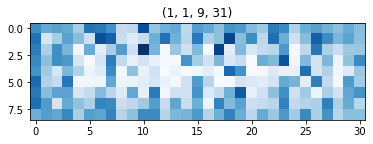

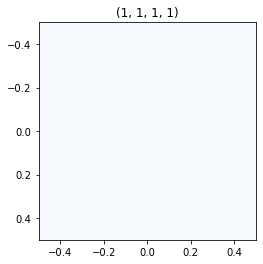

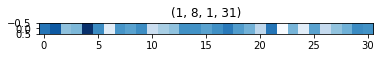

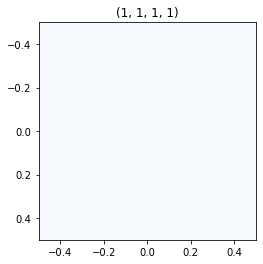

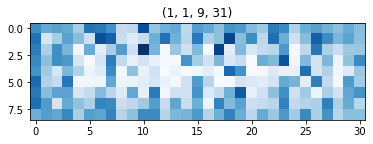


generated matrix summed into recipe vector


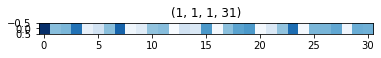

In [153]:
#basic tests of generators and discriminators
test_in=torch.randn(1,100, 1,1)
# print_data(test_in)

# 2d Generator
generator2d=Generator2D()
discriminator2d=Discriminator2D()
#1d Generator
generator1d=Generator1D()
discriminator1d=Discriminator1D()


out=generator2d(test_in)
print_data(out)

out2=discriminator2d(out)
print_data(out2)

out0=generator1d(test_in)
print_data(out0)

out1=discriminator1d(out0)
print_data(out1)
# 
print_data(out)

converted_matrix=convert_tensor_to_recipe(out)
print()
print("generated matrix summed into recipe vector")
print_data(converted_matrix)
